# Life-Cycle Labor Supply with Children
### By Hans Christian Jul Lehmann

## Table of Contents:
* [Exercise 1: Event-Study Graph](#first-bullet)
    - [1A: Handheld Calibration](#firstA-bullet)
    - [1B: Structural Estimation](#firstB-bullet)
* [Exercise 2: Marshallian Elasticity](#second-bullet)
* [Exercise 3: Introducing a Spouse](#third-bullet)
* [Exercise 4: Introducing Childcare Costs](#fourth-bullet)
* [Exercise 6: Stochastic Fertility](#sixth-bullet)

# Setup

In [223]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import minimize
from scipy import optimize

# load local model file
from DynLaborFertModel import DynLaborFertModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1: Event-Study Graph <a class="anchor" id="first-bullet"></a>

## 1.A: Handheld Calibration <a class="anchor" id="firstA-bullet"></a>

In [170]:
### initialize model class
model = DynLaborFertModelClass() 
model_bridge = DynLaborFertModelClass(par={'beta_1':0.051})
model_true = DynLaborFertModelClass(par={'beta_1':0.053})

In [171]:
models = [model, model_bridge, model_true]
# simulate and solve the instances for different values of beta_1
for model in models:
    model.solve()
    model.simulate()

In [172]:
# import local file
from DynLaborFertModel import event_study_graph

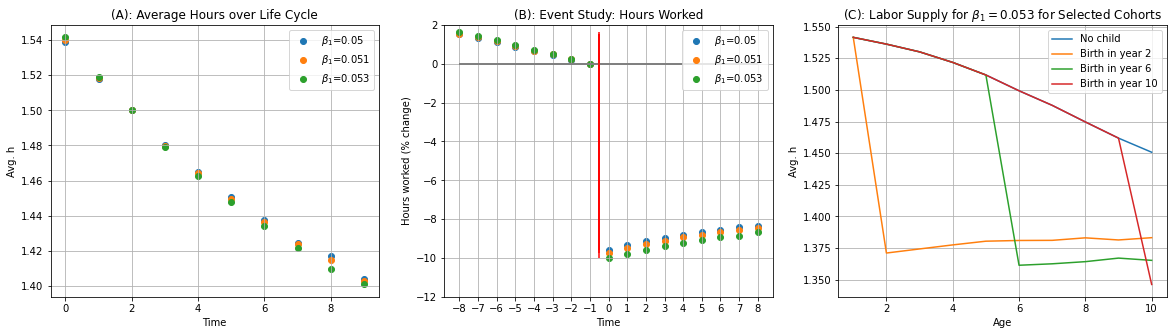

In [201]:
# create a list of beta_1 values for the legend
beta_1_values = [model.par.beta_1 for model in models]

# create the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# plot the Hours graph (Subplot 1)
for model in models:
    axs[0].scatter(range(10), np.mean(getattr(model.sim, 'h'), axis=0), label=r'$\beta_1$'+'='+str(model.par.beta_1))
    axs[0].legend(frameon=True)
    axs[0].set(xlabel='Age', ylabel='Avg. h')
    axs[0].set_title('(A): Average Hours over Life Cycle')
axs[0].grid()

    
# Event-Study Graph (Subplot 2)
for model in models:
    model.simulate()
    axs[1] = event_study_graph(model, ax=axs[1])
axs[1].set(ylim=(-10, 1), yticks=range(-12, 3, 2), xlabel='Time', ylabel='Hours worked (% change)')
axs[1].set_title('(B): Event Study: Hours Worked')
axs[1].grid()


# For Selected Cohorts (Subplot 3)
axs[2].set_xlabel('Age')
axs[2].plot(range(1, model_true.par.simT+1), model_true.sim.h[I].mean(axis=0), label='No child')

for year in range(1, model_true.par.simT+1, 4):
    axs[2].plot(range(1, model_true.par.simT+1), model_true.sim.h[birthyear == year].mean(axis=0), label=f'Birth in year {year+1}')

axs[2].set_ylabel('Avg. h')
axs[2].grid()
axs[2].legend()
axs[2].set_title('(C): Labor Supply for '+r'$\beta_1=0.053$'+ ' for Selected Cohorts')

# adjust spacing between subplots and save the figure
plt.subplots_adjust(wspace=0.2)

## 1.B: Structural Estimation <a class="anchor" id="firstB-bullet"></a>

Here, I perform a mock experiment of structural estimation by finding the $\beta_1$ value which minimizes the distance between the model prediction and the data moment. I will use a 10 percent drop in mean labor hours supplied the year of a birth as the data moment. 

In [ ]:
result = optimize.minimize(model.structural_est, x0=np.array([0.055]), method='Nelder-Mead', bounds = [(0.05, 0.06)], tol=1e-15)

# return "true" beta_1 value
true_beta_1 = result.x[0]

print("True beta_1 value:", true_beta_1)

# Exercise 2: Marshallian Elasticity <a class="anchor" id="second-bullet"></a>

**Plot Behavior**

In [163]:
model = DynLaborFertModelClass(par={'beta_1':0.053}) 
model.solve()

/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_8065/1457352474.py:26: RuntimeWarning: Mean of empty slice
  mean_values = np.nanmean(np.where(condition, getattr(sim, var), np.nan), axis=0)


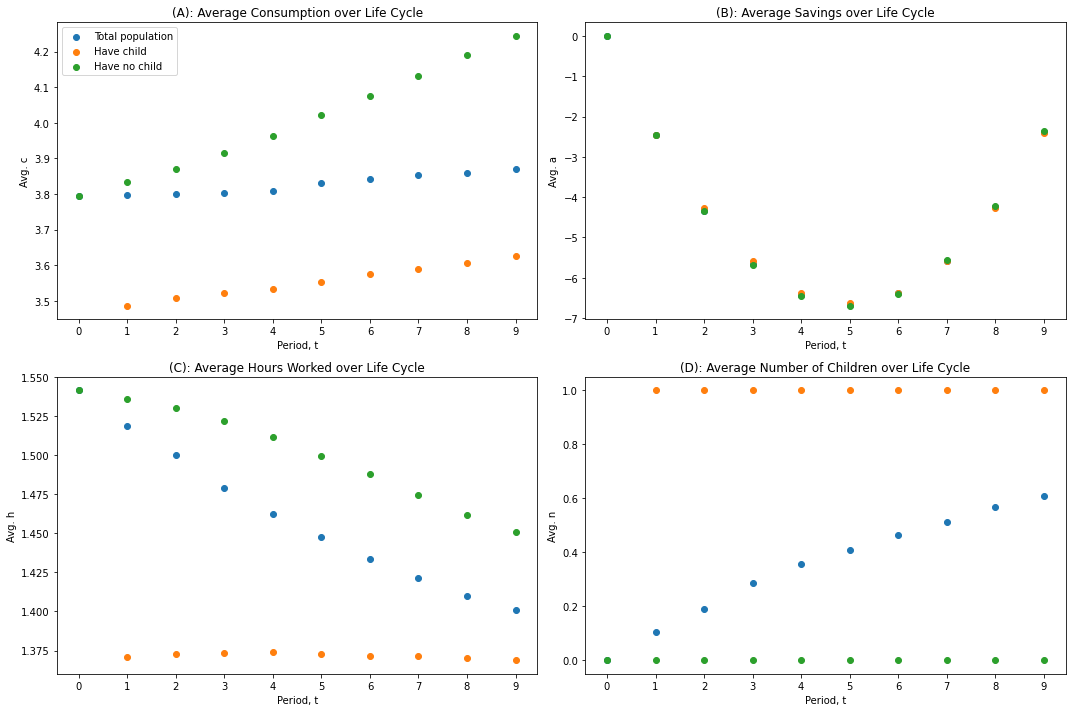

In [195]:
# Unpack parameters and simulation results
par = model.par
sim = model.sim

# Define conditions
Total_population = np.ones(sim.n.shape, dtype=bool)
with_child = np.column_stack((np.zeros(sim.n.shape[0]), sim.n[:, 1:] > 0))
no_child = sim.n == 0

# Initialize a dictionary to store the axes for each plot
ax = {}

# Set up a 2x2 grid of subplots with a larger figure size
fig, ((ax['c'], ax['a']), (ax['h'], ax['n'])) = plt.subplots(2, 2, figsize=(15,10))

# Assign titles for each variable
titles = {'c': 'Consumption', 'a': 'Savings', 'h': 'Hours Worked', 'n': 'Number of Children'}

# Assign panel letters for each variable
panel_letters = {'c': 'A', 'a': 'B', 'h': 'C', 'n': 'D'}

# Iterate over the keys of the dictionary, which correspond to the variables of interest
for var in ('c', 'a', 'h', 'n'):
    # Calculate the mean of the variable of interest under each condition
    for condition, label in zip((unconditional, with_child, without_child), ('Total population', 'Have child', 'Have no child')):
        mean_values = np.nanmean(np.where(condition, getattr(sim, var), np.nan), axis=0)
        # Plot the mean values
        ax[var].scatter(range(par.simT), mean_values, label=label)

    # Set up the labels and ticks of the x-axis and y-axis
    ax[var].set(xlabel='Age', ylabel=f'Avg. {var}', xticks=range(par.simT))
    
    # Set the title for the subplot with the corresponding panel letter
    ax[var].set_title(f'({panel_letters[var]}): Average {titles[var]} over Life Cycle')

    # If we are plotting consumption, add a legend to the plot
    if var == 'c':
        ax[var].legend()

# Ensure a clean layout

fig.tight_layout()

**Plot Marshallian Elasticity**

In [301]:
# import local file
from DynLaborFertModel import simulate_marshallian_elasticity

In [ ]:
model_1pct, ela_total, ela_child, ela_no_child = simulate_marshallian_elasticity(model, 1.01)

ValueError: x and y must be the same size

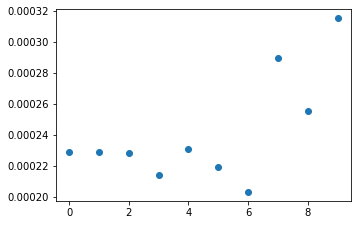

In [276]:
fig = plt.figure(figsize=(3*6, 3*6/1.5))

# plot Marshallian elasticity as a function of age for childless people in all periods
ax = fig.add_subplot(3, 3, 1)
ax.scatter(range(model_1pct.par.simT),np.mean(ela_total,axis=0),label='Total poulation') 
ax.scatter(range(1,model_1pct.par.simT),np.mean(ela_child,axis=0),label='Have child') 
ax.scatter(range(model_1pct.par.simT),np.mean(ela_no_child,axis=0),label='Have no child') 
ax.set(xlabel='Age',ylabel='$e_{M,t}$',xticks=range(model.par.simT))
ax.legend(frameon=True);

# layout 
fig.tight_layout(pad=1); # spacing between subplots

# Exercise 3: Introducing a Spouse <a class="anchor" id="third-bullet"></a>

# Exercise 4: Introducing Childcare Costs <a class="anchor" id="fourth-bullet"></a>

# Exercise 6: Stochastic Fertility <a class="anchor" id="sixth-bullet"></a>